In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
from osgeo import gdal
from mintpy.utils import plot as pp
from mintpy.utils import readfile, utils as ut 
import h5py
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mintpy import view
from mintpy.objects import timeseries
from operator import itemgetter 
import datetime
from datetime import timedelta
from scipy import interpolate
import matplotlib.dates as mdates
from miaplpy.objects.invert_pixel import process_pixel 
from scipy import stats
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.colors as mcolors

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


center = 0
divnorm = mcolors.TwoSlopeNorm(vmin=0,vcenter=0.3, vmax=1)
hex_list = ['#7B0099','#DF2A8E','#ff7b25', '#ffcc5c', '#ffeead']
cmapc=get_continuous_cmap(hex_list)
normc=divnorm

In [3]:
# referencing
# P670
ref_lat = 40.540 
ref_lon = -121.577 

# P669
lat_P669 = 40.492 
lon_P669 = -121.604
# masked
lat_P669 = 40.492 
lon_P669 = -121.6046

# P668
lat_P668 = 40.5098 
lon_P668 = -121.4633

# p665
lat_P665 = 40.456 
lon_P665= -121.526 
#masked
lat_P665 = 40.4555 
lon_P665= -121.5263 
    
# P666
lat_P666 = 40.4653 
lon_P666 = -121.5153 

# P664
lat_P664 = 40.473 
lon_P664 = -121.496 
#masked
lat_P664 = 40.4728 
lon_P664 = -121.4966 

# P667
lat_P667 = 40.4666 
lon_P667 = -121.4679 


points_lalo = [(ref_lat, ref_lon),
               (lat_P669, lon_P669),
               (lat_P668, lon_P668),
               (lat_P667, lon_P667),
               (lat_P666, lon_P666),
               (lat_P665, lon_P665),
               (lat_P664, lon_P664)]

out_dir = './out_figures'



In [434]:
project_dir = './Lassen_mintpy_miaplpy'
# Data is not available on Zenodo because of the size.
# but you can process all using the template files in ./templates if you have the coregistered SLCs generated with ISCE
    
proj_dirs = [project_dir + '/miaplpy',
            project_dir + '/mintpy']


#proj_dirs = ['/Volumes/SaraMNew/scratch/miaplpy_subsets/LassenSenDT042/delaunay_6',
#            './../DATA/Lassen_data/mintpy']

#for prj in proj_dirs:
#    !reference_point.py $prj/velocity.h5 -l $ref_lat -L $ref_lon --lookup $prj/geometryRadar.h5 
    

In [298]:
## read miaplpy files and generate masked lat, lon and velocity
wrap_range = [-1,1]

tsStack_miaplpy = proj_dirs[0] + '/timeseries_SET_ERA5_demErr.h5'
gStack_miaplpy = proj_dirs[0] + '/geometryRadar.h5'
velStack_miaplpy = proj_dirs[0] + '/velocity.h5'
tcoherence_miaplpy = proj_dirs[0] + '/temporalCoherence.h5'


latitude_miaplpy = readfile.read(gStack_miaplpy, datasetName='latitude')[0]
longitude_miaplpy = readfile.read(gStack_miaplpy, datasetName='longitude')[0]
height_miaplpy = readfile.read(gStack_miaplpy, datasetName='height')[0]
temporal_coherence_miaplpy = readfile.read(tcoherence_miaplpy, datasetName='temporalCoherence')[0]
velocity_miaplpy = readfile.read(velStack_miaplpy, datasetName='velocity')[0]

attr_miaplpy = readfile.read_attribute(tsStack_miaplpy)



## read mintpy files and generate masked lat, lon and velocity

tsStack_mintpy = proj_dirs[1] + '/timeseries_SET_ERA5_demErr.h5'
gStack_mintpy = proj_dirs[1] + '/geometryRadar.h5'
velStack_mintpy = proj_dirs[1] + '/velocity.h5'
tcoherence_mintpy = proj_dirs[1] + '/temporalCoherence.h5'


latitude_mintpy = readfile.read(gStack_mintpy, datasetName='latitude')[0]
longitude_mintpy = readfile.read(gStack_mintpy, datasetName='longitude')[0]
temporal_coherence_mintpy = readfile.read(tcoherence_mintpy, datasetName='temporalCoherence')[0]
velocity_mintpy = readfile.read(velStack_mintpy, datasetName='velocity')[0]

attr_mintpy = readfile.read_attribute(tsStack_mintpy)




In [6]:
from scipy.ndimage.filters import gaussian_filter
X = gaussian_filter(longitude_miaplpy, 0.9)
Y = gaussian_filter(latitude_miaplpy, 0.9)
Z = gaussian_filter(height_miaplpy, 0.9)

In [7]:
dem_contour_sequence = np.arange(200, 9000, step=200)

In [30]:
#miaplpy
threshold = 0.5
mask_miaplpy = temporal_coherence_miaplpy > threshold
rows_miaplpy, cols_miaplpy = np.where(mask_miaplpy)

lats_miaplpy = np.array(latitude_miaplpy[rows_miaplpy, cols_miaplpy])
lons_miaplpy = np.array(longitude_miaplpy[rows_miaplpy, cols_miaplpy])
vel_miaplpy = np.array(velocity_miaplpy[rows_miaplpy, cols_miaplpy])*100


# mintpy

threshold = 0.7
mask_mintpy = temporal_coherence_mintpy > threshold
rows_mintpy, cols_mintpy = np.where(mask_mintpy)

lats_mintpy = np.array(latitude_mintpy[rows_mintpy, cols_mintpy])
lons_mintpy = np.array(longitude_mintpy[rows_mintpy, cols_mintpy])
vel_mintpy = np.array(velocity_mintpy[rows_mintpy, cols_mintpy])*100


view.py ./../DATA/Lassen_data/mintpy/geo/geo_velocity.h5 velocity -m ./../DATA/Lassen_data/mintpy/geo/geo_maskTempCoh.h5 --notitle --nocbar --alpha 0.0001 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --nomultilook --sub-lat 40.3632 40.6334 --sub-lon -121.6971 -121.3132 -v -1 1
351936
view.py ./../DATA/Lassen_data/minopy/geo/geo_velocity.h5 velocity -m ./../DATA/Lassen_data/minopy/geo/geo_maskTempCoh.h5 --notitle --nocbar --alpha 0.0001 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --nomultilook --sub-lat 40.3632 40.6334 --sub-lon -121.6971 -121.3132 --wrap --wrap-range -1 1
17163908
save figure to file /Users/Sara/Documents/insarlab/scratch/2022_MiNoPy_Mirzaee_Amelung_Fattahi/out_figures/velocity_lassen_compare_4.png


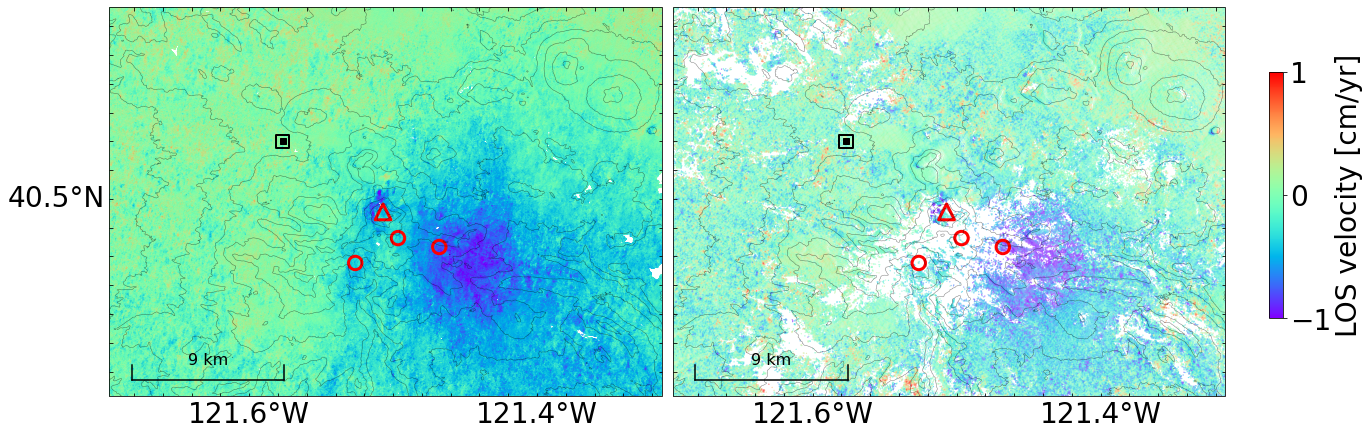

In [10]:
gp_plot = [6,5, 3]

wrap_range = [-1, 1]

data_miaplpy = vel_miaplpy
data_mintpy = vel_mintpy

plt.rcParams["font.size"] = "28"

fsize = 25

#box = ['48.7014:48.8860','-121.9390:-121.675']
box = ['40.3632:40.6334','-121.6971:-121.3132']

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]

#points_lalo = np.array([(-0.1718, -78.6134), (-0.1694, -78.6080)])

dem_file_1 = os.path.expanduser(project_dir + '/dem.dem.wgs84')


# options for view.py

opt = ' --notitle --nocbar --alpha 0.0001 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)


fig, axs = plt.subplots(nrows=1, ncols=2, 
                        figsize=(20,11.4), subplot_kw=dict(projection=ccrs.PlateCarree()))


ax = axs[1]
ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())


data_lass = proj_dirs[1] + '/geo/geo_velocity.h5'
mask_lass = proj_dirs[1] + '/geo/geo_maskTempCoh.h5'

cmd = 'view.py {} velocity -m {}'.format(data_lass, mask_lass) + opt 
#cmd += ' --dem {} --contour-smooth 0.0 --shade-az 45 '.format(dem_file_1)
#cmd += ' --shade-exag 0.5 --shade-min -4000 --shade-max 4000 --fontsize 28'
cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
cmd += ' -v -{f} {f} '.format(f=wrap_range[1])



d_v, atr, inps = view.prep_slice(cmd)
im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]


im = ax.scatter(lons_mintpy, lats_mintpy, c=data_mintpy, cmap='rainbow',  s=0.2, vmin=wrap_range[0], vmax=wrap_range[1],
                alpha=1, marker='.', transform=ccrs.PlateCarree())

print(len(lats_mintpy))

ax.contour(X, Y, Z, dem_contour_sequence, colors='k', alpha=0.5, linewidths=0.5, transform=ccrs.PlateCarree())

ax.scatter(-121.507, 40.491, s=250, c='None', alpha=1, edgecolors='red'
           , marker='^', linewidths=3,transform=ccrs.PlateCarree())

ax.scatter(points_lalo[0][1], points_lalo[0][0], s=180, c='None', alpha=1, edgecolors='black', 
           marker='s', linewidths=2, transform=ccrs.PlateCarree())

for t in gp_plot:
    poi = points_lalo[t]
    ax.scatter(poi[1], poi[0],s=180, c='None', alpha=1, edgecolors='red', 
               marker='o', linewidths=3, transform=ccrs.PlateCarree())

#for poi in points_lalo:
#    ax.scatter(poi[1], poi[0],s=80, color='black', marker='o', transform=ccrs.PlateCarree())

#ax.text(points_lalo[0][1] - 0.01, points_lalo[0][0]-0.01,'GGPA', color='black', transform=ccrs.PlateCarree())
#ax.text(points_lalo[1][1] + 0.005, points_lalo[1][0]+0.005,'P', color='black', transform=ccrs.PlateCarree())
#ax.text(ref_lon - 0.02, ref_lat-0.01,'QUI4', color='black', transform=ccrs.PlateCarree())


gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = False
gl.ylabels_right=False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-121.6, -121.4])
gl.ylocator = mticker.FixedLocator([40.3, 40.5])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}



ax = axs[0]
ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())
data_lass = proj_dirs[0] + '/geo/geo_velocity.h5'
mask_lass = proj_dirs[0] + '/geo/geo_maskTempCoh.h5'


cmd = 'view.py {} velocity -m {}'.format(data_lass, mask_lass) + opt 
#cmd += ' --dem {} --contour-smooth 0.0 --shade-az 45 --contour-linewidth 0.8 '.format(dem_file_1)
#cmd += ' --shade-exag 0.5 --shade-min -4000 --shade-max 4000 --fontsize 28 '
cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
cmd += ' --wrap --wrap-range -{f} {f} '.format(f=wrap_range[1])

d_v, atr, inps = view.prep_slice(cmd)
im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]


im = ax.scatter(lons_miaplpy, lats_miaplpy, c=data_miaplpy, cmap='rainbow',  vmin=wrap_range[0], vmax=wrap_range[1],
                s=0.2, alpha=1, marker='.', transform=ccrs.PlateCarree())
print(len(lats_miaplpy))

ax.contour(X, Y, Z, dem_contour_sequence, colors='k', alpha=0.5, linewidths=0.5, transform=ccrs.PlateCarree())

ax.scatter(points_lalo[0][1], points_lalo[0][0], s=180, c='None', alpha=1, edgecolors='black', 
           marker='s', linewidths=2, transform=ccrs.PlateCarree())

ax.scatter(-121.507, 40.491, s=250, c='None', alpha=1, edgecolors='red'
           , marker='^', linewidths=3,transform=ccrs.PlateCarree())


for t in gp_plot:
    poi = points_lalo[t]
    ax.scatter(poi[1], poi[0],s=180, c='None', alpha=1, edgecolors='red', 
               marker='o', linewidths=3, transform=ccrs.PlateCarree())

#ax.text(points_lalo[0][1] - 0.01, points_lalo[0][0]-0.01,'GGPA', color='black', transform=ccrs.PlateCarree())
#ax.text(points_lalo[1][1] + 0.005, points_lalo[1][0]+0.005,'P', color='black', transform=ccrs.PlateCarree())
#ax.text(ref_lon - 0.02, ref_lat - 0.01,'QUI4', color='black', transform=ccrs.PlateCarree())


gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlabels_bottom = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-121.6, -121.4])
gl.ylocator = mticker.FixedLocator([40.3, 40.5])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#cbar_ax = fig.add_axes([0.43, 0.06, 0.15, 0.01])
cbar_ax = fig.add_axes([0.93, 0.36, 0.01, 0.3])

fig.colorbar(im, cax=cbar_ax, ticks=[wrap_range[0],0,wrap_range[1]], label='LOS velocity [cm/yr]', orientation='vertical')


fig.subplots_adjust(hspace=0.02, wspace=0.02)

out_file = os.path.abspath(out_dir + '/velocity_lassen_compare_4.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()


In [410]:
gps_points = ['P670', 'P669', 'P668', 'P667', 'P666', 'P665', 'P664']
gps_ts = {}

for gp in gps_points:
    gps_file = './../DATA/GPS_data/{}.tenv3.txt'.format(gp)
    file1 = open(gps_file,"r") 
    lines_gp = file1.readlines()
    file1.close()
    gps_ts[gp] = []
    indx = np.hstack([1, np.arange(6,13), np.arange(14,17)]).astype(int)
    for t in lines_gp:
        A = t.split()
        gps_ts[gp].append(itemgetter(*indx)(A))
    


In [435]:
tsStack_miaplpy = proj_dirs[0] + '/timeseries_SET_ERA5_demErr.h5'
gStack_miaplpy = proj_dirs[0] + '/geometryRadar.h5'

attr_miaplpy = readfile.read_attribute(tsStack_miaplpy)


stack_obj = timeseries(tsStack_miaplpy)
stack_obj.open(print_msg=False)
date_list_miaplpy = stack_obj.get_date_list()
num_dates_miaplpy = len(date_list_miaplpy)



tsStack_mintpy = proj_dirs[1] + '/timeseries_SET_ERA5_demErr.h5'
gStack_mintpy = proj_dirs[1] + '/geometryRadar.h5'

attr_mintpy = readfile.read_attribute(tsStack_mintpy)


stack_obj = timeseries(tsStack_mintpy)
stack_obj.open(print_msg=False)
date_list_mintpy = stack_obj.get_date_list()
num_dates_mintpy = len(date_list_mintpy)

In [412]:

## gps
yg_miaplpy = {}
xg_miaplpy = {}
incangle_miaplpy = {}

coord_miaplpy = ut.coordinate(attr_miaplpy, gStack_miaplpy)
for t, poi in enumerate(points_lalo):
    yg_miaplpy[gps_points[t]], xg_miaplpy[gps_points[t]] = coord_miaplpy.geo2radar(poi[0], poi[1])[0:2]
    incangle_miaplpy[gps_points[t]] = np.deg2rad(readfile.read(gStack_miaplpy, 
                                                              datasetName='incidenceAngle')[0][yg_miaplpy[gps_points[t]], 
                                                                                               xg_miaplpy[gps_points[t]]])

azangle_miaplpy = np.deg2rad(float(attr_miaplpy['HEADING'])) 


In [413]:
coh_mat = {}
slc_stack_file = project_dir + '/miaplpy/slcStack.h5'

for t, po in enumerate(points_lalo):
    if t > 0:
        yg, xg = coord_miaplpy.geo2radar(po[0], po[1])[0:2]
        vec_refined, temp_quality, coh_mat[gps_points[t]], shp, amp, data, col0, row0 = process_pixel((yg, xg), slc_stack_file)


(100, 100)
0.2939967412182035
(100, 100)
0.3698889349159134
(100, 100)
0.37244454409514777
(100, 100)
0.49101489169855345
(100, 100)
0.28731035776655856
(100, 100)
0.32707981425770727


In [441]:
# referencing
# P670
ref_lat = 40.540 
ref_lon = -121.577 

ref_lat = 40.5399
ref_lon = -121.5772

# P669
lat_P669 = 40.492 
lon_P669 = -121.604
# masked
lat_P669 = 40.492 
lon_P669 = -121.6046

# P668
lat_P668 = 40.5098 
lon_P668 = -121.4633

# p665
lat_P665 = 40.456 
lon_P665= -121.526 
#masked
lat_P665 = 40.4564 
lon_P665= -121.5247 
    
# P666
lat_P666 = 40.4653 
lon_P666 = -121.5153 

# P664
lat_P664 = 40.473 
lon_P664 = -121.496 
#masked
lat_P664 = 40.4728 
lon_P664 = -121.4966 

# P667
lat_P667 = 40.4666 
lon_P667 = -121.4679 

lat_P667 = 40.4655 
lon_P667 = -121.4671 


points_lalo = [(ref_lat, ref_lon),
               (lat_P669, lon_P669),
               (lat_P668, lon_P668),
               (lat_P667, lon_P667),
               (lat_P666, lon_P666),
               (lat_P665, lon_P665),
               (lat_P664, lon_P664)]

In [442]:
#lat_miaplpy1, lon_miaplpy1 = coord_miaplpy.radar2geo(1051, 5791)[0:2]

ts_miaplpy = np.zeros([len(points_lalo), num_dates_miaplpy])
ts_mintpy = np.zeros([len(points_lalo), num_dates_mintpy])



###

for t in range(len(points_lalo)):
    coord = points_lalo[t]
    dates_miaplpy, ts_miaplpy[t, :] = ut.read_timeseries_lalo(coord[0], coord[1], tsStack_miaplpy, lookup_file=gStack_miaplpy, ref_lat=ref_lat, ref_lon=ref_lon,
                         win_size=10, unit='cm', print_msg=True)[0:2]
    
    dates_mintpy, ts_mintpy[t, :] = ut.read_timeseries_lalo(coord[0], coord[1], tsStack_mintpy, lookup_file=gStack_mintpy, ref_lat=ref_lat, ref_lon=ref_lon,
                         win_size=10, unit='cm', print_msg=True)[0:2]
    
ts_miaplpy = ts_miaplpy[:, 2::]
ts_mintpy = ts_mintpy[:, 2::]

dates_miaplpy = dates_miaplpy[2::]
dates_mintpy = dates_mintpy[2::]


input lat / lon: 40.5399 / -121.5772
corresponding y / x: 1017 / 7464
input lat / lon: 40.5399 / -121.5772
corresponding y / x: 219 / 516
input lat / lon: 40.492 / -121.6046
corresponding y / x: 1422 / 7863
input lat / lon: 40.492 / -121.6046
corresponding y / x: 300 / 542
input lat / lon: 40.5098 / -121.4633
corresponding y / x: 1144 / 4386
input lat / lon: 40.5098 / -121.4633
corresponding y / x: 244 / 310
input lat / lon: 40.4655 / -121.4671
corresponding y / x: 1495 / 4128
input lat / lon: 40.4655 / -121.4671
corresponding y / x: 315 / 293
input lat / lon: 40.4653 / -121.5153
corresponding y / x: 1549 / 5296
input lat / lon: 40.4653 / -121.5153
corresponding y / x: 325 / 371
input lat / lon: 40.4564 / -121.5247
corresponding y / x: 1627 / 5544
input lat / lon: 40.4564 / -121.5247
corresponding y / x: 341 / 388
input lat / lon: 40.4728 / -121.4966
corresponding y / x: 1466 / 4830
input lat / lon: 40.4728 / -121.4966
corresponding y / x: 309 / 340


In [443]:
xx = {}
xx_gnss = {}
xx_d = {}
xx_gd = {}


for t in range(len(points_lalo)):
    xx[gps_points[t]] = [datetime.datetime.strptime(i[0], '%y%b%d') for i in gps_ts[gps_points[t]][1:]]
    xx_gnss[gps_points[t]] = [datetime.datetime.strptime(i[0], '%y%b%d') for i in gps_ts[gps_points[t]][1:]]
    
print(xx.keys(), gps_points)

date_min = np.max([xx[t][0] for t in gps_points])
date_min = np.max([dates_miaplpy[0],date_min])

date_max = np.min([xx[t][-1] for t in gps_points])
date_max = np.min([dates_miaplpy[-1],date_max])

ind_miaplpy1 = np.argmin([np.abs((x - date_min).days) for x in dates_miaplpy])
ind_mintpy1 = np.argmin([np.abs((x - date_min).days) for x in dates_mintpy])
ind_miaplpy2 = len(dates_miaplpy) - np.argmin([np.abs((date_max-x).days) for x in dates_miaplpy])
ind_mintpy2 = len(dates_mintpy) - np.argmin([np.abs((date_max-x).days) for x in dates_mintpy])
print(ind_miaplpy1, ind_miaplpy2, ind_mintpy1, ind_mintpy2)

ind_gps = {}
ind_gps_max = {}

for po in gps_points:
    
    if po in ['P670']:
        ind_gps[po] = np.argmin([np.abs((x - date_min).days) for x in xx[po]]) - 1
    else:
        ind_gps[po] = np.argmin([np.abs((x - date_min).days) for x in xx[po]]) 
        
    
    xx[po] = xx[po][ind_gps[po]::]
    xx_gnss[po] = xx_gnss[po][ind_gps[po]::]
    xx_d[po] = [(x-xx['P670'][0]).days for x in xx[po]]
    xx_gd[po] = [(x-xx['P670'][0]).days for x in xx[po]]
    



dict_keys(['P670', 'P669', 'P668', 'P667', 'P666', 'P665', 'P664']) ['P670', 'P669', 'P668', 'P667', 'P666', 'P665', 'P664']
0 48 0 48


In [444]:


E = {}
N = {}
U = {}
dlos = {}
dlos2 = {}
dlos_intp = {}

for po in gps_points:
    E[po] = np.array([float(i[3])*100 for i in gps_ts[po][1:]])
    N[po] = np.array([float(i[5])*100 for i in gps_ts[po][1:]])
    U[po] = np.array([float(i[7])*100 for i in gps_ts[po][1:]])
    dlos[po] = (N[po]*np.sin(azangle_miaplpy) - 
                E[po]*np.cos(azangle_miaplpy))*np.sin(incangle_miaplpy[po]) + U[po]*np.cos(incangle_miaplpy[po])
    dlos2[po] = (N[po]*np.sin(azangle_miaplpy) - 
                E[po]*np.cos(azangle_miaplpy))*np.sin(incangle_miaplpy[po]) + U[po]*np.cos(incangle_miaplpy[po])

for po in gps_points:
    print(po)
    res = stats.linregress(xx_d[po], dlos[po][ind_gps[po]::] - dlos[po][ind_gps[po]])

    new_los = res.intercept + res.slope * np.array(xx_d[po])
    dlospo = dlos[po][ind_gps[po]::] - dlos[po][ind_gps[po]]
    hdx = np.where(np.abs(dlospo - new_los) > 3)[0]
    dlospo = np.delete(dlospo, hdx)
    xx[po] = np.delete(np.array(xx[po]), hdx)
    xx_d[po] = np.delete(np.array(xx_d[po]), hdx)
    dlos2[po] = dlospo
 

P670
P669
P668
P667
P666
P665
P664


P667
-0.39922244172753696
P665
-0.37070155257982
P664
-0.37070155257982


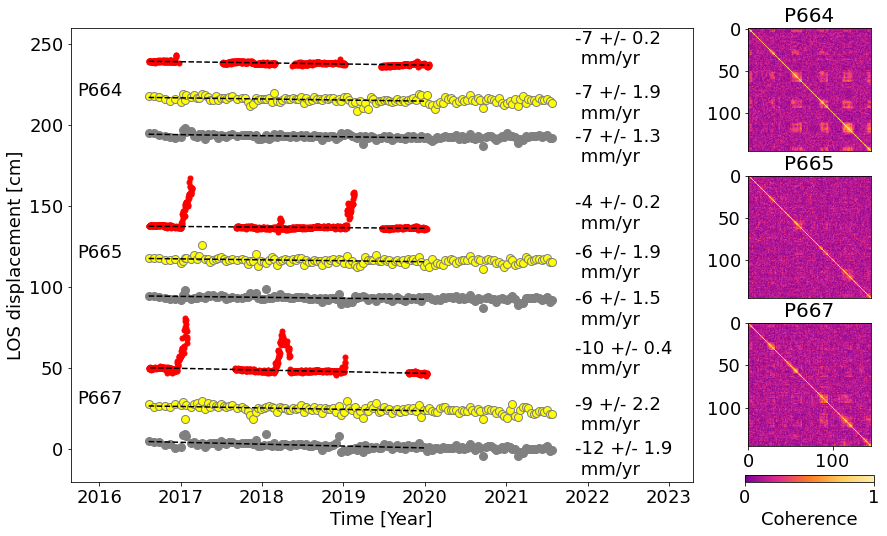

In [445]:
plt.rcParams["font.size"] = "18"

gps_index = [3, 5, 6]

years = mdates.YearLocator()


fig = plt.figure(figsize=(18, 10), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, right=0.5, top=0.98, bottom=0.35,
                        hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs1[0,0])

gs2 = fig.add_gridspec(nrows=3, ncols=1, left=0.53, right=0.65, top=0.98, bottom=0.40,
                        hspace=0.2, wspace=0.2)

ax2 = fig.add_subplot(gs2[0])
ax3 = fig.add_subplot(gs2[1])
ax4 = fig.add_subplot(gs2[2])


aax = [ax4, ax3, ax2]

shifts = [10, 100, 200]
shifts2 = np.array([[-5, 18, 40], 
                    [-5, 18, 38],
                    [-5, 18, 40]])

x_miaplpy = [(x-dates_miaplpy[ind_miaplpy1]).days for x in dates_miaplpy[ind_miaplpy1::]] 
x_mintpy = [(x-dates_mintpy[ind_mintpy1]).days for x in dates_mintpy[ind_mintpy1::]] 


res = stats.linregress(xx_d['P670'], dlos2['P670'])


mi = 0
for t in gps_index:
    po = gps_points[t]
    print(po)
    
    #x_gnss = [(x-xx[po][0]).days for x in xx[po]] 

    
    ref_los1 = res.intercept + res.slope * np.array(xx_gd[po])
    ref_los = res.intercept + res.slope * np.array(xx_d[po])

    print(ref_los[0])
    y_gnss = dlos[po][ind_gps[po]::] - dlos[po][ind_gps[po]] - ref_los1 + ref_los1[0] + shifts[mi] + shifts2[mi, 2]
    #y_gnss = dlos2[po] - ref_los + ref_los[0] + shifts[mi] + shifts2[mi, 2]
    y_miaplpy = ts_miaplpy[t, ind_miaplpy1::] - ts_miaplpy[t, ind_miaplpy1] + shifts[mi] + shifts2[mi, 1]
    y_mintpy = ts_mintpy[t, ind_mintpy1::] - ts_mintpy[t, ind_mintpy1] + shifts[mi] + shifts2[mi, 0]
    
    ax1.plot(xx_gnss[po], y_gnss , 'o',markersize=5, color='red')
    ax1.plot(dates_miaplpy[ind_miaplpy1::], y_miaplpy , 'o', markerfacecolor='yellow', markeredgecolor='gray', markersize=8)
    ax1.plot(dates_mintpy[ind_mintpy1::], y_mintpy, 'o', markerfacecolor='gray', markeredgecolor='gray', markersize=8)
    
        
    resm = stats.linregress(x_miaplpy[0:-ind_miaplpy2], y_miaplpy[0:-ind_miaplpy2])
    ax1.plot(dates_miaplpy[ind_miaplpy1:-ind_miaplpy2], resm.intercept + resm.slope * np.array(x_miaplpy[ind_miaplpy1:-ind_miaplpy2]), '--', color='k')
    
    ax1.text(dates_miaplpy[-1] + timedelta(days=100), 
             ts_miaplpy[t, -1] - ts_miaplpy[t, ind_miaplpy1] + shifts[mi] + shifts2[mi, 1]-10, 
             '{:.0f} +/- {:.1f}\n mm/yr'.format(resm.slope*3652.5, resm.stderr*3652.5), color='black')
    
    
    resm1 = stats.linregress(x_mintpy[0:-ind_mintpy2], y_mintpy[0:-ind_mintpy2])
    ax1.plot(dates_mintpy[ind_mintpy1:-ind_mintpy2], resm1.intercept + resm1.slope * np.array(x_mintpy[ind_mintpy1:-ind_mintpy2]), '--', color='k')
    
    ax1.text(dates_mintpy[-1] + timedelta(days=100), 
             ts_mintpy[t, -1] - ts_mintpy[t, ind_mintpy1] + shifts[mi] + shifts2[mi, 0]-15, 
             '{:.0f} +/- {:.1f}\n mm/yr'.format(resm1.slope*3652.5, resm1.stderr*3652.5), color='black')
    

    #resm2 = stats.linregress([x_gnss[0], x_gnss[-1]], [y_gnss[0], y_gnss[-1]])
    y_gnss = dlos2[po] - ref_los + ref_los[0] + shifts[mi] + shifts2[mi, 2]
    resm2 = stats.linregress(xx_d[po], y_gnss)
    ax1.plot(xx[po], resm2.intercept + resm2.slope * np.array(xx_d[po]), '--', color='k')
    #ax1.plot(xx[po], res.intercept + res.slope * np.array(x_gnss), '--', color='b')
    
    ax1.text(dates_miaplpy[-1] + timedelta(days=100), 
             dlos[po][-1] - dlos[po][ind_gps[po]] - ref_los[-1] + ref_los[0] + shifts[mi] + shifts2[mi, 2], 
             '{:.0f} +/- {:.1f}\n mm/yr'.format(resm2.slope*3652.5, resm2.stderr*3652.5), color='black')
    
    
    
    mi += 1

mi = 0
for t in gps_index:
    po = points_lalo[t]
    if t > 0:
        im3=aax[mi].imshow(np.abs(coh_mat[gps_points[t]]), vmin=0, vmax=1, cmap=cmapc)
        aax[mi].get_xaxis().set_visible(False)
        aax[mi].get_yaxis().set_visible(True)
        aax[mi].set_title(gps_points[t], fontsize=20)
        mi += 1
aax[0].get_xaxis().set_visible(True)

mi = 0
for t in gps_index:
    po = gps_points[t]
    if po != 'P670':
        ax1.text(dates_miaplpy[0] - timedelta(days=320), shifts[mi] + shifts2[mi, 1], po, color='black')
        mi += 1
    


ax1.set_ylim(-20,260)
ax1.set_xlim(dates_miaplpy[ind_miaplpy] - timedelta(days=350), dates_miaplpy[-1] + timedelta(days=630))

ax1.set_ylabel('LOS displacement [cm]')
ax1.get_xaxis().set_ticks([])
ax1.tick_params()


years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.set_xlabel('Time [Year]')


cbar_ax2 = fig.add_axes([0.54, 0.35, 0.10, 0.01])
fig.colorbar(im3, cax=cbar_ax2, ticks=[0, 1], label='Coherence', orientation='horizontal')



#ax1.legend([ 'GPS','Phase linking', 'Small baseline' ], bbox_to_anchor=(0.99, 1.05), loc=1, framealpha=1)
plt.savefig(out_dir + '/ts_coh_mat_Lassen_2.eps', bbox_inches='tight', transparent=True, dpi=300)
plt.savefig(out_dir + '/ts_coh_mat_Lassen_2.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()
